# Population differentiation

## Input

Input files:

In [2]:
# input data
outdir     = "results_differentiation_CIcol"
metasam_fn = "metadata/samples.meta_phenotypes.txt"
callset_fn = "/home/xavi/dades/VariationAg1k/data/phase2.AR1/variation/main/zarr2/ag1000g.phase2.ar1.pass/"

# define populations
outcode    = "dif_CIcol_PM"
popl       = ["alive","dead"]   # 2 populations to compare
popc       = "phenotype"
sub1l      = ["CIcol","CIcol"]  # traits to subset
sub1c      = "population"
chromlist  = list(("2R","2L","3R","3L","X"))

# exclude these samples
excludec   = "ox_code"
excludel   = list(("NO RES"))

# window lengths for base-based windows
window_length = 10000
step_fraction = 0.2
step_percent  = int(step_fraction * 100)
step_length   = int(window_length * step_fraction)

# window lengths for SNP blocks
block_len_snp = 200
step_frac_snp = 0.2
step_perc_snp = int(step_frac_snp * 100)
step_len_snp  = int(block_len_snp * step_frac_snp)

# window lengths for haplotype blocks
block_len_hap = 200
step_frac_hap = 0.2
step_perc_hap = int(step_frac_hap * 100)
step_len_hap  = int(block_len_hap * step_frac_hap)

zscore_CI  = 0.01

# length to explore EHH decay around Fst peaks
ehh_num_hap = 10000

Libraries:

In [2]:
%%capture
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from matplotlib.backends.backend_pdf import PdfPages
import zarr
import pandas
import allel
import h5py
import itertools

Functions:

In [4]:
# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1.3,rc={"lines.linewidth": 1},
        font="Arial",palette="bright")

# function: % of values over absolute threshold
zscore_thr = scipy.stats.norm.ppf(1-zscore_CI/2) # divide by 2 if 2-sided
def prop_gt_thresh(val, threshold=zscore_thr,minsize=10):
    boolVal = ~np.isnan(val)
    val1 = val[boolVal]
    if val1.size < minsize:
        return 0
    x = np.abs(val1) > threshold
    z = np.count_nonzero(x)
    r = z/len(val1)
    return r

# import gff
def geneset_gff(geneset):
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pandas.DataFrame.from_items(items)

# PCA plot function
def plot_pca_coords(
    coords, model, pc1, pc2,
    colorpop1,colorpop2,title="PCA",figsizex=6, figsizey=6):
    fig, ax = plt.subplots(figsize=(figsizex, figsizey))
    sns.despine(ax=ax, offset=10)
    x = coords[:, pc1]
    y = coords[:, pc2]
    ax.plot(x[(samples_sub[popc] == popl[0]).values], y[(samples_sub[popc] == popl[0]).values], 
        marker='o', linestyle=' ', label=popl[0], markersize=6, color=colorpop1, mfc='none')
    ax.plot(x[(samples_sub[popc] == popl[1]).values], y[(samples_sub[popc] == popl[1]).values],
        marker='o', linestyle=' ', label=popl[1], markersize=6, color=colorpop2, mfc='none')
    ax.set_xlabel('PC%s (%.2f%%)' % (pc1+1,model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.2f%%)' % (pc2+1,model.explained_variance_ratio_[pc2]*100))
    ax.set_title(title)
    ax.legend(loc='best')
    return fig,ax;

# PCA variance explained histogram
def plot_pcavarexp(
    pcamodel,
    color="blue",
    title="Variance explained",figsizex=5, figsizey=4):
    fig, ax = plt.subplots(figsize=(figsizex, figsizey))
    sns.despine(ax=ax, offset=10)
    y = 100 * pcamodel.explained_variance_ratio_
    x = np.arange(len(y))
    ax.set_xticks(x + .4)
    ax.set_xticklabels(x + 1)
    ax.bar(x, y,color=color)
    ax.set_xlabel('PC')
    ax.set_ylabel('Variance (%)')
    ax.set_title(title)
    return fig;



## Load data

### Genotypes, haplotypes, variants & samples

Load data for all variants & genotypes. Population and sample structure:

In [5]:
# load samples list with sample code, groupings, locations etc.
samples_df   = pandas.read_csv(metasam_fn, sep='\t')
samples_bool = (
    samples_df[popc].isin(popl).values & 
    samples_df[sub1c].isin(sub1l).values &
    ~samples_df[excludec].isin(excludel).values
)
samples_sub  = samples_df[samples_bool]
samples_sub.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
popdict = dict()
for popi in popl: 
    popdict[popi]  = samples_sub[samples_sub[popc] == popi].index.tolist()

# add an extra population composed of all other locations
popdict["all"] = []
for popi in popl:
    popdict["all"] = popdict["all"] + popdict[popi]
    
# report
print("Data:")
print("* Samples     = ", samples_sub.shape[0])
print("* Populations = ", set(samples_sub[popc]))
samples_sub.groupby(popc).size()

Data:
* Samples     =  71
* Populations =  {'alive', 'dead'}


phenotype
alive    31
dead     40
dtype: int64

In [9]:
samples_sub

,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,phenotype,insecticide
0,AY0006-C,Tia_dPM_8,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,92062494,29.87,dead,pirimiphos_methyl
1,AY0007-C,Tia_dPM_16,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,99436108,30.92,dead,pirimiphos_methyl
2,AY0010-C,Tia_dPM_38,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,102737152,32.70,dead,pirimiphos_methyl
3,AY0011-C,Tia_dPM_44,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,97128450,31.25,dead,pirimiphos_methyl
4,AY0012-C,Tia_dPM_51,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,98242336,31.81,dead,pirimiphos_methyl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,AY0087-C,Tia_dPM_46,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,101458232,32.56,dead,pirimiphos_methyl
67,AY0088-C,Tia_dPM_52,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,95140584,30.75,dead,pirimiphos_methyl
68,AY0089-C,Tia_aPM_4,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,92383724,29.04,alive,pirimiphos_methyl
69,AY0090-C,Tia_aPM_13,CIcol,Cote_d'Ivoire,Tiassale,David_Weetman,NaN,2012.0,M,F,96210618,30.94,alive,pirimiphos_methyl


Load variant, genotypes, haplotypes, accessibility, etc. data:

In [5]:
# declare objects with variant data
genotyp_seg = dict()
genalco_seg = dict()
genvars_seg = dict()
genveff_seg = dict()
accessi_arr = dict()
chr_stop    = dict()
callset     = zarr.open(callset_fn)
snpeff_zr   = zarr.open(snpeff_fn)

for chrom in chromlist:
    
    # GENOTYPES
    # variants of genotypes
    callset_var = callset[chrom]["variants"]
    genvars = allel.VariantChunkedTable(callset_var,names=["POS","REF","ALT","num_alleles"],index="POS") # variants
    genveff = allel.VariantChunkedTable(snpeff_zr[chrom]["variants"],names=["POS","ANN"],index="POS") # variant effects
    chr_stop[chrom] = genvars["POS"][:].max() # last variant in chrom
    # genotype data
    callset_gen = callset[chrom]["calldata"]["genotype"]
    genotyp     = allel.GenotypeChunkedArray(callset_gen) # genotypes
    genotyp_sub = genotyp.subset(sel0=None, sel1=samples_bool)
    # allele counts in pops. Only data from "all" is used now, so subpops
    # can be changed later (if genalco is re-calculated with new popdict)
    genalco_sep = genotyp_sub.count_alleles_subpops(subpops=popdict)
    # subset data: segregating alleles, biallelic and no singletons
    is_seg      = genalco_sep["all"].is_segregating()[:] # segregating
    is_bia      = genvars["num_alleles"] > 1            # biallelic "==2" | multiallelic ">1"
    is_nosing   = genalco_sep["all"][:,:2].min(axis=1)>2 # no singletons
    genotyp_seg[chrom] = genotyp_sub.compress((is_bia & is_seg & is_nosing))
    genvars_seg[chrom] = genvars.compress((is_bia & is_seg & is_nosing))
    genalco_seg[chrom] = genalco_sep.compress((is_bia & is_seg & is_nosing))
    genveff_seg[chrom] = genveff[:].compress((is_bia & is_seg & is_nosing))
    # report
    print("chr %s:\tGenotypes retained:\t%i out of %i (%.2f%%)" % (
        chrom,genotyp_seg[chrom].shape[0],genotyp_sub.shape[0],
        genotyp_seg[chrom].shape[0]/genotyp_sub.shape[0]*100))

chr 2R:	Genotypes retained:	1774638 out of 15425222 (11.50%)
chr 2L:	Genotypes retained:	1440446 out of 11524923 (12.50%)
chr 3R:	Genotypes retained:	1779897 out of 14481509 (12.29%)
chr 3L:	Genotypes retained:	1272220 out of 10640388 (11.96%)
chr X:	Genotypes retained:	494256 out of 5765843 (8.57%)


In [6]:
accessi_df  = h5py.File(accessi_fn,mode="r")

for chrom in chromlist:

    # ACCESSIBILITY
    # accessibility data
    accessi_arr[chrom] = accessi_df[chrom]["is_accessible"][:]
    

In [7]:
hapcall          = zarr.open(haploty_fn)
haploty_seg_pop1 = dict()
haploty_seg_pop2 = dict()
haploty_seg      = dict()
hapvars_seg      = dict()
hapalco_seg      = dict()
hapalco_seg      = dict()


for chrom in chromlist:

    # HAPLOTYPES
    # variants in haplotypes
    hapcall_var = hapcall[chrom]["variants"]
    hapvars     = allel.VariantChunkedTable(
        hapcall_var,names=["POS","REF","ALT"],index="POS")
    # phased genotypes
    hapcall_gen = hapcall[chrom]["calldata"]["genotype"]
    haploty_gen = allel.GenotypeChunkedArray(hapcall_gen)
    # conver phased genotypes to haplotyes
    haploty_sam  = hapcall[chrom]["samples"][:].astype(str)
    hapsam_bool  = np.isin(haploty_sam, np.array(samples_sub["ox_code"]))
    samphap_bool = np.isin(haploty_sam,np.array(samples_sub["ox_code"]))
    samphap_boop = np.concatenate((samphap_bool,samphap_bool))
    haploty_hap  = haploty_gen.to_haplotypes()
    haploty_sub  = haploty_hap.subset(sel0=None,sel1=samphap_boop)

    # haplotype dicts
    is_samp_in_hap = np.isin(np.array(samples_sub["ox_code"]),haploty_sam)
    hap_ids        = np.array(list(itertools.chain(*[[s + ' a', s + ' b'] for s in haploty_sam[samphap_bool]])))
    hap_pops       = np.array(list(itertools.chain(*[[s, s] for s in np.array(samples_sub[popc][is_samp_in_hap])])))
    hap_pops_df    = pandas.DataFrame(data={ popc : hap_pops})

    # pop dicts for haplotype data
    popdicthap = dict()
    for popi in popl: 
        popdicthap[popi]  = hap_pops_df[hap_pops_df[popc] == popi].index.tolist()

    popdicthap["all"] = []
    for popi in popl:
        popdicthap["all"] = popdicthap["all"] + popdicthap[popi]

    # genotype counts in hap data
    hapalco      = haploty_sub.count_alleles_subpops(subpops=popdicthap)
    # subset haplotypes: segregating alleles and no singletons
    is_hapseg    = hapalco["all"].is_segregating()[:] # segregating
    is_hapnosing = hapalco["all"][:,:2].min(axis=1)>2 # no singletons
    haploty_seg[chrom] = haploty_sub.compress(is_hapseg & is_hapnosing)
    hapvars_seg[chrom] = hapvars.compress(is_hapseg & is_hapnosing)
    hapalco_seg[chrom] = hapalco.compress(is_hapseg & is_hapnosing)
    # segregating per population
    haploty_seg_pop1[chrom] = haploty_seg[chrom].subset(
        sel1=samples_sub[popc].isin({popl[0]}).values)
    haploty_seg_pop2[chrom] = haploty_seg[chrom].subset(
        sel1=samples_sub[popc].isin({popl[1]}).values)
    # report
    print("chr %s:\tHaplotypes retained:\t%i out of %i (%.2f%%)" % (
        chrom,haploty_seg[chrom].shape[0],haploty_sub.shape[0],
        haploty_seg[chrom].shape[0]/haploty_sub.shape[0]*100))

chr 2R:	Haplotypes retained:	1667869 out of 12047846 (13.84%)
chr 2L:	Haplotypes retained:	1172080 out of 8906423 (13.16%)
chr 3R:	Haplotypes retained:	1321513 out of 10752701 (12.29%)
chr 3L:	Haplotypes retained:	932617 out of 7897666 (11.81%)
chr X:	Haplotypes retained:	333399 out of 4472265 (7.45%)


Import GFF geneset:

In [14]:
geneset = allel.FeatureTable.from_gff3(gffann_fn,attributes=['ID', 'Parent'])
geneset = geneset_gff(geneset)

/home/xavi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


## Statistics along genome

### Variant density

Calculate # of variants per bp:

In [15]:
vad_dat = dict() # variant densitiy

for chrom in chromlist:

    #### VARIANT DENSITIY ####
    # variant density per chromosome
    vad_dat[chrom] = allel.windowed_statistic(
        pos       = genvars_seg[chrom]['POS'][:],
        values    = np.ones(len(genvars_seg[chrom]['POS'][:]))/window_length,
        statistic = np.sum,
        size      = window_length,
        step      = step_length,
        fill=0)
    

### Population differentiation $F_{ST}$

The $F_{ST}$ estimate summarises the difference in allele frequencies averaged over all SNPs in the dataset. It can be calculated chromosome-wise (with standard error), per SNP, and in a windowed function.

* $F_{ST} \approx 0 $ implies panmixis, ie total interbreeding of both populations
* $F_{ST} \approx 1 $ implies all genetic variation is explained by population structure, ie no genetic diversity is *shared* between both populations

$F_{ST}$ calculated in **equal-sized SNP blocks** along the chromosome (same number of SNPs per window).

I focus on top $F_{ST}$ windows above a certain threshold.

In [16]:
fst_est       = dict() # fst, per SNP block
fsti_est      = dict() # fst, per SNP
fst_max_ix    = dict()
fst_max_coord = dict()
fst_wib       = dict()
fst_wib_start = dict()
fst_wib_end   = dict()
fst_dat       = dict()

for chrom in chromlist:

    #### FST ####
    # calculate block-wise and chromosome-wise estimate
    fst_est[chrom] = allel.blockwise_hudson_fst(
        ac1=genalco_seg[chrom][popl[0]],
        ac2=genalco_seg[chrom][popl[1]],
        blen=block_len_snp)
    # calculate Hudson's Fst along windows
    fst_dat[chrom] = allel.moving_hudson_fst(
        ac1=genalco_seg[chrom][popl[0]],
        ac2=genalco_seg[chrom][popl[1]],
        size=block_len_snp,step=step_len_snp)
    fst_wib[chrom] = allel.moving_statistic(genvars_seg[chrom]["POS"][:],
        statistic=lambda v: (v[0] + v[-1]) / 2, size=block_len_snp,step=step_len_snp)
    fst_wib_start[chrom] = allel.moving_statistic(genvars_seg[chrom]["POS"][:],
        statistic=lambda v: v[0], size=block_len_snp,step=step_len_snp)
    fst_wib_end[chrom] = allel.moving_statistic(genvars_seg[chrom]["POS"][:],
        statistic=lambda v: v[-1], size=block_len_snp,step=step_len_snp)

    # Fst per SNP
    fsti_dat = allel.hudson_fst(
        ac1=genalco_seg[chrom][popl[0]], 
        ac2=genalco_seg[chrom][popl[1]])
    fsti_est[chrom] = fsti_dat[0] / fsti_dat[1]


In [17]:
for chrom in chromlist:
    
    print("Fst chr %s, %s~%s (block len=%i SNPs, step=%i%%), mean Fst = %.6f +/- %.6f" % (
            chrom,popl[0],popl[1],block_len_snp,step_perc_snp,fst_est[chrom][0],fst_est[chrom][1]))

Fst chr 2R, alive~dead (block len=200 SNPs, step=20%), mean Fst = -0.000043 +/- 0.000056
Fst chr 2L, alive~dead (block len=200 SNPs, step=20%), mean Fst = -0.000014 +/- 0.000053
Fst chr 3R, alive~dead (block len=200 SNPs, step=20%), mean Fst = -0.000140 +/- 0.000046
Fst chr 3L, alive~dead (block len=200 SNPs, step=20%), mean Fst = 0.000510 +/- 0.000062
Fst chr X, alive~dead (block len=200 SNPs, step=20%), mean Fst = -0.000038 +/- 0.000137


### Nucleotide diversity $\pi$

**Nucleotide diversity** estimate $\pi$ per chromosome and per population:

In [18]:
pid_dat1      = dict() # nucleotide diversity pi, per win
pid_dat2      = dict()

for chrom in chromlist:
    
    #### NUCLEOTIDE DENSITY ####
    # pi per population:
    pid_dat1[chrom] = allel.windowed_diversity(
        pos=genvars_seg[chrom]['POS'][:],
        ac=genalco_seg[chrom][popl[0]],
        size=window_length,step=step_length,
        is_accessible=accessi_arr[chrom])
    pid_dat2[chrom] = allel.windowed_diversity(
        pos=genvars_seg[chrom]['POS'][:],
        ac=genalco_seg[chrom][popl[1]],
        size=window_length,step=step_length,
        is_accessible=accessi_arr[chrom])
    

### Tajima's $D$

Tajima's $D$ is the difference between the mean number of pairwise differences and the number of segregating sites, each scaled so that they are expected to be the same in a neutrally evolving population of constant size.

Tajima's $D$ distinguishes between a DNA sequence evolving neutrally and one **evolving under a non-random process** (be it  directional or balancing selection, demographic expansion or contraction, genetic hitchhiking, or introgression).

* In *Anopheles*, it is often negative due to long-standing population expansion effect

In [19]:
tad_dat1      = dict() # tajima D, per win
tad_dat2      = dict()

for chrom in chromlist:
    
    #### TAJIMA D ####
    # D per population:
    tad_dat1[chrom] = allel.windowed_tajima_d(
        pos=genvars_seg[chrom]['POS'][:],
        ac=genalco_seg[chrom][popl[0]],
        size=window_length,step=step_length)
    
    tad_dat2[chrom] = allel.windowed_tajima_d(
        pos=genvars_seg[chrom]['POS'][:],
        ac=genalco_seg[chrom][popl[1]],
        size=window_length,step=step_length)
    

### Sequence divergence $Dxy$

$Dxy$ measures **sequence divergence** in absolute terms. Should it be similar to $\pi$ (nucleotide diversity)?

In [20]:
dxy_dat       = dict() # Dxy sequence divergence, per win

for chrom in chromlist:
    
    #### Dxy DIVERGENCE ####
    # Dxy per population:
    dxy_dat[chrom] = allel.windowed_divergence(
        pos=genvars_seg[chrom]['POS'][:],
        ac1=genalco_seg[chrom][popl[0]],
        ac2=genalco_seg[chrom][popl[1]],
        size=window_length,step=step_length,
        is_accessible=accessi_arr[chrom])


### Waterson's $\\\theta$

Watterson's $\\\theta$ estimator is a method for **describing the genetic diversity in a population**. It is estimated by counting the **number of polymorphic sites**. It is a measure of the "population mutation rate" (the product of the effective population size and the neutral mutation rate) from the observed nucleotide diversity of a population. 

In [21]:
wat_dat1      = dict() # watterson theta
wat_dat2      = dict()

for chrom in chromlist:
    
    #### WATTERSON THETA ####
    
    # per population:
    wat_dat1[chrom] = allel.windowed_watterson_theta(
        pos=genvars_seg[chrom]['POS'][:],
        ac=genalco_seg[chrom][popl[0]],
        size=window_length,step=step_length)
    wat_dat2[chrom] = allel.windowed_watterson_theta(
        pos=genvars_seg[chrom]['POS'][:],
        ac=genalco_seg[chrom][popl[1]],
        size=window_length,step=step_length)


### Selection analyses based on LD in haplotypes

A selected allele maintains LD with neighbouring hitch-hiking variants (which, together, constitute a haplotype) until recombination breaks down these associations. It is possible to detect **positive selection** by examining **extended regions of strong LD, i.e. long haplotypes** (sets of co-segregating alleles). These regions descend from quick sweeps of a positively selected allele+its neighbouring haplotype, that has not yet been broken down by recombination.

LD-based selection methods' advantages include:

* Useful to identify variants in incomplete or **soft sweeps**, i.e. when the selected **mutation has low frequency**
* Useful for short-term balancing selection.

### Integrated Halotype score $iHS$

The **integrated haplotype score** $iHS$ compares the area under the curve defined by EHH for the derived and ancestral variants as one travels further from the core region. It is based on the differential LD levels surrounding a positively selected allele compared to a background allele in the same position (Voight et al. Plos Biol 2006). By calculating the area under the $EHH$ decay curve, it is able to capture two scenarios:

* a strong EHH decay in a short distance can indicate selection
* a minor EHH decay over very long distance can also indicate selection

The raw $iHS$ score can be standardized (mean=0, variance=1) so that the value is independent of the allele counts at the core SNP. Standardization is necessary to compare $iHS$ values of different SNPs. Since $iHS$ is standardized using a genome-wide distribution of SNP counts, it provides a **natural measure of how unusual a haplotype is**. Interpretation of **$iHS$ scores**:
* Extremely negative $iHS<-2$ implies long haplotyes carrying the derived allele.
* Large positive $iHS >2$ implies long haplotypes carrying the ancestral allele.
* Small $iHS\approx0$ implies that the rate of EHH decay is similar in both the ancestral and derived alleles.

When examining raw scores, **both extremes can imply selection**. Thus, it's useful to take a look at **absolute standardized IHS score** ($|iHS_{st}|$).

When compared to XP-$EHH$, $iHS$ can detect incomplete sweeps more easily (~50-80%, Pickrell et al. Genome Res 2009), but it's less useful in near-fixation scenarios (Voight et al Plos Biol 2006).

In [22]:
%%capture
ihs_dat1_raw  = dict() # iHS, per win
ihs_dat1_std  = dict()
ihs_dat2_raw  = dict()
ihs_dat2_std  = dict()
ihs_wib       = dict()
ihs_xpop_raw  = dict()
ihs_xpop_std  = dict()

for chrom in chromlist:  
    
    #### iHS INTEGRATED HAPLOTYPE SCORE ####
    # calculate IHS pop1
    ihs_dat1_raw[chrom] = allel.ihs(h=haploty_seg_pop1[chrom],pos=hapvars_seg[chrom]["POS"][:],min_ehh=0.05,min_maf=0,include_edges=True,is_accessible=accessi_arr[chrom])
    ihs_dat1_std[chrom] = allel.standardize_by_allele_count(score=ihs_dat1_raw[chrom],aac=hapalco_seg[chrom]["all"][:,1],diagnostics=False)
    
    # calculate IHS pop2
    ihs_dat2_raw[chrom] = allel.ihs(h=haploty_seg_pop2[chrom],pos=hapvars_seg[chrom]["POS"][:],min_ehh=0.05,min_maf=0,include_edges=True,is_accessible=accessi_arr[chrom])
    ihs_dat2_std[chrom] = allel.standardize_by_allele_count(score=ihs_dat2_raw[chrom],aac=hapalco_seg[chrom]["all"][:,1],diagnostics=False)
    
    # cross-population IHS
    ihs_xpop_raw[chrom] = np.log(ihs_dat1_raw[chrom]/ihs_dat2_raw[chrom])
    ihs_xpop_std[chrom] = allel.standardize_by_allele_count(score=ihs_xpop_raw[chrom],aac=hapalco_seg[chrom]["all"][:,1],diagnostics=False)
    
    # mean data per hap block
    ihs_wib[chrom]             = dict()
    ihs_wib[chrom]["start"]    = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[0], size=block_len_hap,step=step_len_hap)
    ihs_wib[chrom]["end"]      = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[-1], size=block_len_hap,step=step_len_hap)
    ihs_wib[chrom]["pos"]      = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: (v[0] + v[-1]) / 2, size=block_len_hap,step=step_len_hap)
    ihs_wib[chrom]["ihs1_std"] = allel.moving_statistic(ihs_dat1_std[chrom][0],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    ihs_wib[chrom]["ihs2_std"] = allel.moving_statistic(ihs_dat2_std[chrom][0],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    ihs_wib[chrom]["ihs1_raw"] = allel.moving_statistic(ihs_dat1_raw[chrom],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    ihs_wib[chrom]["ihs2_raw"] = allel.moving_statistic(ihs_dat2_raw[chrom],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    ihs_wib[chrom]["ihs1_frq"] = allel.moving_statistic(ihs_dat1_std[chrom][0],statistic=prop_gt_thresh,size=block_len_hap,step=step_len_hap)
    ihs_wib[chrom]["ihs2_frq"] = allel.moving_statistic(ihs_dat2_std[chrom][0],statistic=prop_gt_thresh,size=block_len_hap,step=step_len_hap)


### $nS_{L}$: number of segregating sites by length

$nS_{L}$ statistic combines information on the distribution of fragment lengths between mutations with the distribution of the number of segregating sites between all pairs of chromosomes, and is based on taking the **ratio of haplotype homozygosity for the derived and ancestral alleles**, an approach also taken by iHS. However, the crucial difference between nSL and iHS is that **nSL measures the length of a segment of haplotype homozygosity between a pair of haplotypes in terms of number of mutations in the remaining haplotypes** in the data set in the same region (Ferrer-Admetlla MBE 2014).

In [23]:
%%capture
nsl_dat1_raw  = dict() # nSL, per win
nsl_dat1_std  = dict()
nsl_dat2_raw  = dict()
nsl_dat2_std  = dict()
nsl_wib       = dict()
nsl_xpop_raw  = dict()
nsl_xpop_std  = dict()

for chrom in chromlist:
    
    nsl_wib[chrom] = dict()
    
    #### nSL SEGREGATING SITES PER LENGTH ####
    # calculate and nSL per pop1
    nsl_dat1_raw[chrom] = allel.nsl(h=haploty_seg_pop1[chrom])
    nsl_dat1_std[chrom] = allel.standardize_by_allele_count(score=nsl_dat1_raw[chrom],aac=hapalco_seg[chrom]["all"][:,1],diagnostics=False)
    
    # calculate and nSL per pop2
    nsl_dat2_raw[chrom] = allel.nsl(h=haploty_seg_pop2[chrom])
    nsl_dat2_std[chrom] = allel.standardize_by_allele_count(score=nsl_dat2_raw[chrom],aac=hapalco_seg[chrom]["all"][:,1],diagnostics=False)
    
    # cross-population nSL
    nsl_xpop_raw[chrom] = allel.xpnsl(h1=haploty_seg_pop1[chrom],h2=haploty_seg_pop2[chrom])
    nsl_xpop_std[chrom] = allel.standardize_by_allele_count(score=nsl_xpop_raw[chrom],aac=hapalco_seg[chrom]["all"][:,1],diagnostics=False)
    
    # mean data per hap block
    nsl_wib[chrom]             = dict()
    nsl_wib[chrom]["start"]    = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[0],  size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["end"]      = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[-1], size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["pos"]      = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: (v[0] + v[-1]) / 2, size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["nsl1_std"] = allel.moving_statistic(nsl_dat1_std[chrom][0],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["nsl2_std"] = allel.moving_statistic(nsl_dat2_std[chrom][0],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["nsl1_raw"] = allel.moving_statistic(nsl_dat1_raw[chrom],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["nsl2_raw"] = allel.moving_statistic(nsl_dat2_raw[chrom],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["nsl1_frq"] = allel.moving_statistic(nsl_dat1_std[chrom][0],statistic=prop_gt_thresh,size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["nsl2_frq"] = allel.moving_statistic(nsl_dat2_std[chrom][0],statistic=prop_gt_thresh,size=block_len_hap,step=step_len_hap)
    nsl_wib[chrom]["nsl_xpop_std"] = allel.moving_statistic(nsl_xpop_std[chrom][0],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)


### XP-$EHH$

From Sabeti et al. Nature 2007 (SM):

> Empirically, the resulting distribution of XP-EHH
logratios (in both simulations and in the human genome) is approximately normal. We note, however, that, in general, there was a small skew towards one population; we
neglect this asymmetry when calculating significance scores. We normalize the XP-EHH logratio such that the set of all such logratios has zero mean and unit variance. We denote these normalized XP-EHH logratios by " XP-EHH scores". **Outlying XP-EHH scores are potentially indicative of selection in a particular population**. An **XP-EHH score is directional**: a positive score suggests selection is likely to have happened in population A, whereas a negative score suggests the same about population B

So:

* XP-EHH > 0 is selection in pop1
* XP-EHH < 0 is selection in pop2



In [24]:
%%capture
xeh_dat_raw  = dict() # iHS, per win
xeh_dat_std  = dict()
xeh_wib      = dict()

for chrom in chromlist:  
    
    #### XP-EHH INTEGRATED HAPLOTYPE SCORE ####
    # calculate XP-EHH pop1~pop2
    xeh_dat_raw[chrom] = allel.xpehh(h1=haploty_seg_pop1[chrom], h2=haploty_seg_pop2[chrom],pos=hapvars_seg[chrom]["POS"][:],
                                     min_ehh=0.05,max_gap=1e4,gap_scale=1e3)
    xeh_dat_std[chrom] = allel.standardize_by_allele_count(score=xeh_dat_raw[chrom],aac=hapalco_seg[chrom]["all"][:,1],diagnostics=False)
    
    # mean data per hap block
    xeh_wib[chrom]            = dict()
    xeh_wib[chrom]["start"]   = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[0], size=block_len_hap,step=step_len_hap)
    xeh_wib[chrom]["end"]     = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[-1], size=block_len_hap,step=step_len_hap)
    xeh_wib[chrom]["pos"]     = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: (v[0] + v[-1]) / 2, size=block_len_hap,step=step_len_hap)
    xeh_wib[chrom]["xeh_std"] = allel.moving_statistic(xeh_dat_std[chrom][0],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    xeh_wib[chrom]["xeh_raw"] = allel.moving_statistic(xeh_dat_raw[chrom],statistic=np.nanmean,size=block_len_hap,step=step_len_hap)
    xeh_wib[chrom]["xeh_frq"] = allel.moving_statistic(xeh_dat_std[chrom][0],statistic=prop_gt_thresh,size=block_len_hap,step=step_len_hap)

### Garud's $H$

Garud's various $H$ statistics can **detect and discriminate hard and soft sweeps**. Based on haplotype homozygosities (Garud et al. Plos Genetics 2015).

* $H_{12}$: estimates haplotype homozygosity after combining frequencies of the two most frequent haplotypes. Detects both hard and soft sweeps with similar sensitivity. It takes values $0 \lt H_{12} \le 1$, where $H_{12} \approx 1$ implies a **selective sweep**.

* $H_{123}$: similar, but takes into account three most common haplotypes. It takes values $0 \lt H_{123} \le 1$.

* $H_{2}/H_{1}$: compares haplotype homozygosities with and without the most common haplotype. After normalization, it can take values $0 \lt H_{2}/H_{1} \le 1$. It can discriminate between soft and hard seeps: **soft sweeps** have $H_{2}/H_{1} \approx 1$, whereas **hard sweeps** have $H_{2}/H_{1} \approx 0$

In [25]:
gah_wib         = dict()

for chrom in chromlist:
    
    # calculate Garud H per blocks
    gah_wib[chrom] = dict() 
    gah_wib[chrom]["gah1"]  = allel.moving_garud_h(h=haploty_seg_pop1[chrom],size=block_len_hap,step=step_len_hap)
    gah_wib[chrom]["gah2"]  = allel.moving_garud_h(h=haploty_seg_pop2[chrom],size=block_len_hap,step=step_len_hap)
    gah_wib[chrom]["pos"]   = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: (v[0] + v[-1]) / 2, size=block_len_hap,step=step_len_hap)
    gah_wib[chrom]["start"] = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[0], size=block_len_hap,step=step_len_hap)
    gah_wib[chrom]["end"]   = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[-1], size=block_len_hap,step=step_len_hap)


### Haplotype diversity

**Haplotype diversity** or ***h*** is the haplotypic equivalent of $\pi$ or nucleotide diversity. It is a measure of the uniqueness of a particular haplotype in a given population. It represents the probability that two randomly haplotypes alleles are different. 
* $h=0$ if all haplotypes are the same
* $h=1$ if all haplotypes are different

In [26]:
hdi_wib  = dict()

for chrom in chromlist:
    
    # calculate haplotype diversity per window
    hdi_wib[chrom] = dict()
    hdi_wib[chrom]["hapdiv1"] = allel.moving_haplotype_diversity(h=haploty_seg_pop1[chrom],size=block_len_hap,step=step_len_hap)
    hdi_wib[chrom]["hapdiv2"] = allel.moving_haplotype_diversity(h=haploty_seg_pop2[chrom],size=block_len_hap,step=step_len_hap)
    hdi_wib[chrom]["pos"]     = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: (v[0] + v[-1]) / 2, size=block_len_hap,step=step_len_hap)
    hdi_wib[chrom]["start"]   = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[0], size=block_len_hap,step=step_len_hap)
    hdi_wib[chrom]["end"]     = allel.moving_statistic(hapvars_seg[chrom]["POS"][:],statistic=lambda v: v[-1],size=block_len_hap,step=step_len_hap)



### Tables

Save files:

In [27]:
#### difb: SNP blocks Fst  ####
print("difb...")
# open table for Fst block data
difb_f = "%s/%s_tab_difb.csv" % (outdir,outcode)
difb_c = ["chrom","start","end","strand","Fst"]
np.savetxt(difb_f,[difb_c],fmt="%s",delimiter="\t")
for chrom in chromlist:

    fidf = pandas.DataFrame(data={
    "chrom"  : [chrom] * len(fst_wib[chrom]*1e6),
    "start"  : np.ceil(fst_wib_start[chrom]).astype(int),
    "end"    : np.ceil(fst_wib_end[chrom]).astype(int),
    "strand" : ["+"] * len(fst_wib[chrom]*1e6),
    "Fst"    : fst_dat[chrom].astype(float)
    })
    fidf = fidf[difb_c]
    fidf.to_csv(open(difb_f,mode="a"),
                sep="\t",index=False,header=False,na_rep="NA")
open(difb_f,mode="a").close()
    


#### selb: Haplotype blocks ####
print("selb...")
# open table for selection block data
selb_f = "%s/%s_tab_selb.csv" % (outdir,outcode)
selb_c = ["chrom","start","end","strand",
           "nsl1_std","nsl2_std","nsl1_raw","nsl2_raw","nsl1_frq","nsl2_frq","nsl_xpop",
           "ihs1_std","ihs2_std","ihs1_raw","ihs2_raw","ihs1_frq","ihs2_frq",
           "gah1_h12","gah1_h123","gah1_h2h1",
           "gah2_h12","gah2_h123","gah2_h2h1",
           "hapdiv1","hapdiv2",
           "xehh_raw","xehh_std","xehh_frq"]
np.savetxt(selb_f,[selb_c],fmt="%s",delimiter="\t")
for chrom in chromlist:
    
    fidf = pandas.DataFrame(data={
    "chrom"    : [chrom] * len(nsl_wib[chrom]["start"]*1e6),
    "start"    : np.ceil(nsl_wib[chrom]["start"]).astype(int),
    "end"      : np.ceil(nsl_wib[chrom]["end"]).astype(int),
    "strand"   : ["+"] * len(nsl_wib[chrom]["start"]),
    "nsl1_std" : nsl_wib[chrom]["nsl1_std"].astype(float),
    "nsl2_std" : nsl_wib[chrom]["nsl2_std"].astype(float),
    "nsl1_raw" : nsl_wib[chrom]["nsl1_raw"].astype(float),
    "nsl2_raw" : nsl_wib[chrom]["nsl2_raw"].astype(float),
    "nsl1_frq" : nsl_wib[chrom]["nsl1_frq"].astype(float),
    "nsl2_frq" : nsl_wib[chrom]["nsl2_frq"].astype(float),
    "nsl_xpop" : nsl_wib[chrom]["nsl_xpop_std"].astype(float),
    "ihs1_std" : ihs_wib[chrom]["ihs1_std"].astype(float),
    "ihs2_std" : ihs_wib[chrom]["ihs2_std"].astype(float),
    "ihs1_raw" : ihs_wib[chrom]["ihs1_raw"].astype(float),
    "ihs2_raw" : ihs_wib[chrom]["ihs2_raw"].astype(float),
    "ihs1_frq" : ihs_wib[chrom]["ihs1_frq"].astype(float),
    "ihs2_frq" : ihs_wib[chrom]["ihs2_frq"].astype(float),
    "gah1_h12" : gah_wib[chrom]["gah1"][1].astype(float),
    "gah1_h123": gah_wib[chrom]["gah1"][2].astype(float),
    "gah1_h2h1": gah_wib[chrom]["gah1"][3].astype(float),
    "gah2_h12" : gah_wib[chrom]["gah2"][1].astype(float),
    "gah2_h123": gah_wib[chrom]["gah2"][2].astype(float),
    "gah2_h2h1": gah_wib[chrom]["gah2"][3].astype(float),
    "hapdiv1"  : hdi_wib[chrom]["hapdiv1"].astype(float),
    "hapdiv2"  : hdi_wib[chrom]["hapdiv2"].astype(float),
    "xehh_std" : xeh_wib[chrom]["xeh_std"].astype(float),
    "xehh_raw" : xeh_wib[chrom]["xeh_raw"].astype(float),
    "xehh_frq" : xeh_wib[chrom]["xeh_frq"].astype(float)
    })
    fidf = fidf[selb_c]
    fidf.to_csv(open(selb_f,mode="a"),sep="\t",index=False,header=False,na_rep="NA")
open(selb_f,mode="a").close()

    

    
#### difs: per SNP fst + effects ####
# open table for Fst SNP-wise data
print("difs...")
difs_f = "%s/%s_tab_difs.csv" % (outdir,outcode)
difs_c = ["chrom","start","Fst","effect"]
np.savetxt(difs_f,[difs_c],fmt="%s",delimiter="\t")
for chrom in chromlist:
    
    fidf = pandas.DataFrame(data={
    "chrom"    : [chrom] * len(genvars_seg[chrom]["POS"][:]),
    "start"    : genvars_seg[chrom]["POS"][:].astype(int),
    "Fst"      : fsti_est[chrom],
    "effect"   : genveff_seg[chrom]["ANN"]
    })
    fidf = fidf[difs_c]
    fidf.to_csv(open(difs_f,mode="a"),
                sep="\t",index=False,header=False,na_rep="NA")
open(difs_f,mode="a").close()

    

    
#### sels: per SNP selection ####
# open table for selection SNP-wise data
print("sels...")
sels_f = "%s/%s_tab_sels.csv" % (outdir,outcode)
sels_c = ["chrom","start",
           "ihs1_std","ihs2_std","nsl1_std","nsl2_std",
           "nsl_xpop","ihs_xpop","xehh_std"]
np.savetxt(sels_f,[sels_c],fmt="%s",delimiter="\t")
for chrom in chromlist:

    fidf = pandas.DataFrame(data={
    "chrom"    : [chrom] * len(hapvars_seg[chrom]["POS"][:]),
    "start"    : hapvars_seg[chrom]["POS"][:].astype(int),
    "nsl1_std" : nsl_dat1_std[chrom][0],
    "nsl2_std" : nsl_dat2_std[chrom][0],
    "ihs1_std" : ihs_dat1_std[chrom][0],
    "ihs2_std" : ihs_dat2_std[chrom][0],
    "nsl_xpop" : nsl_xpop_std[chrom][0],
    "ihs_xpop" : ihs_xpop_std[chrom][0],
    "xehh_std" : xeh_dat_std[chrom][0],
    })
    fidf = fidf[sels_c]
    fidf.to_csv(open(sels_f,mode="a"),
                sep="\t",index=False,header=False,na_rep="NA")
open(sels_f,mode="a").close()



difb...
selb...
difs...
sels...


In [28]:
import subprocess
subprocess.call("sed -i \"s/|/\t/g\" %s" % difs_f, shell=True) 

0

### PCA & hierarchical clustering:

#### PCA of whole chromosome with genotypes

PCA can reveal underlying **structure of the inter-population differences**. We perform the analysis using:
* SNPs segregating in both populations of interest
* if they're biallelic
* so as to use independent variables, we remove SNPs linked by linkage disequilibrium. 

Concatenate genotypes and remove SNPs in LD:

In [29]:
# remove SNPs in linkage disequilibrium from a genotype array
def ld_prune(
    gn, size, step, 
    threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(
            gn, 
            size=size, 
            step=step, 
            threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('# iteration', i+1, 'retaining', n, 
              'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [30]:
genotyp_seg_naltAll     = np.empty((0,samples_sub.shape[0]),dtype="int8")
genotyp_seg_naltAll_LDp = np.empty((0,samples_sub.shape[0]),dtype="int8")
genotyp_seg_nalt        = dict()
genotyp_seg_nalt_LDp    = dict()

for chrom in chromlist:
    
    # concatenate all genotypes in all chromosomes
    genotyp_seg_nalt[chrom] = genotyp_seg[chrom].to_n_alt()[:]
    genotyp_seg_naltAll = np.concatenate(
        (genotyp_seg_naltAll[:],
         genotyp_seg_nalt[chrom]))
    print("chr %s: %i genotypes added, %i total" % (
        chrom,genotyp_seg_nalt[chrom].shape[0],genotyp_seg_naltAll[:].shape[0]))

    # prune LD-linked genotypes
    genotyp_seg_nalt_LDp[chrom] = ld_prune(
        genotyp_seg_nalt[chrom],size=500, step=200,threshold=.1, n_iter=5)
    genotyp_seg_naltAll_LDp = np.concatenate(
        (genotyp_seg_naltAll_LDp[:],
         genotyp_seg_nalt_LDp[chrom]))

chr 2R: 1774638 genotypes added, 1774638 total
# iteration 1 retaining 148773 removing 1625865 variants
# iteration 2 retaining 37580 removing 111193 variants
# iteration 3 retaining 15644 removing 21936 variants
# iteration 4 retaining 8156 removing 7488 variants
# iteration 5 retaining 4857 removing 3299 variants
chr 2L: 1440446 genotypes added, 3215084 total
# iteration 1 retaining 110108 removing 1330338 variants
# iteration 2 retaining 24268 removing 85840 variants
# iteration 3 retaining 9849 removing 14419 variants
# iteration 4 retaining 5228 removing 4621 variants
# iteration 5 retaining 3216 removing 2012 variants
chr 3R: 1779897 genotypes added, 4994981 total
# iteration 1 retaining 179885 removing 1600012 variants
# iteration 2 retaining 47809 removing 132076 variants
# iteration 3 retaining 20045 removing 27764 variants
# iteration 4 retaining 10395 removing 9650 variants
# iteration 5 retaining 6132 removing 4263 variants
chr 3L: 1272220 genotypes added, 6267201 total
# i

Plot PCAs:

In [1]:
outdir

NameError: name 'outdir' is not defined

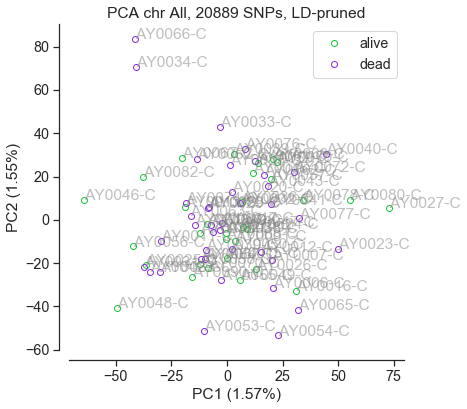

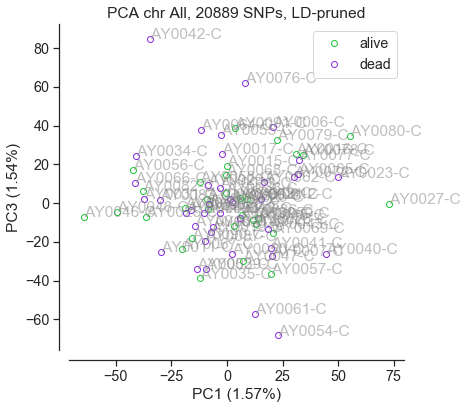

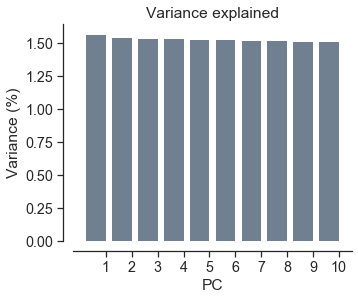

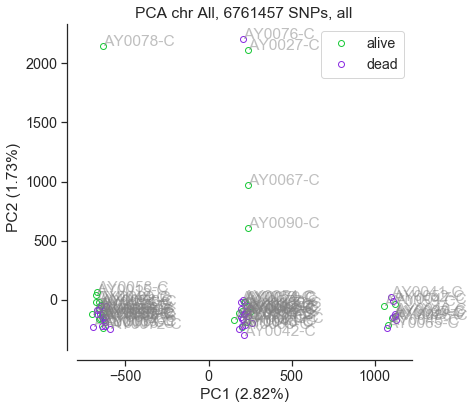

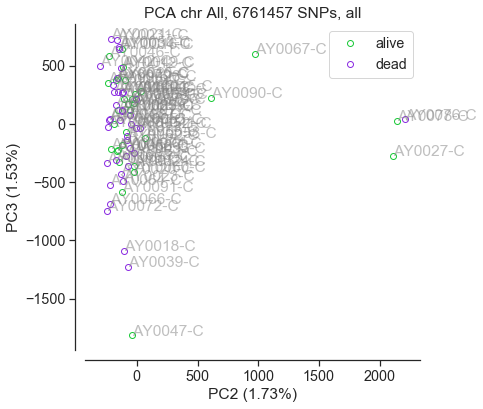

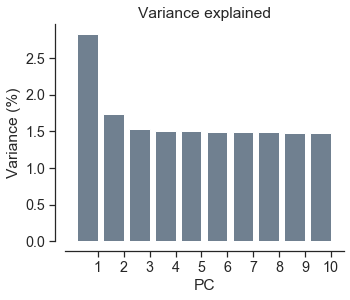

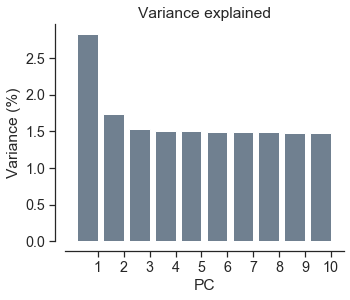

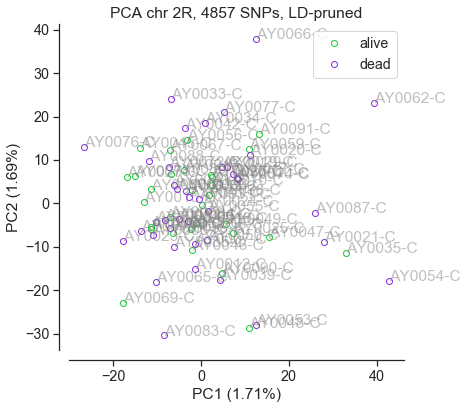

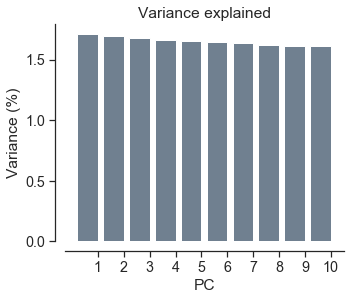

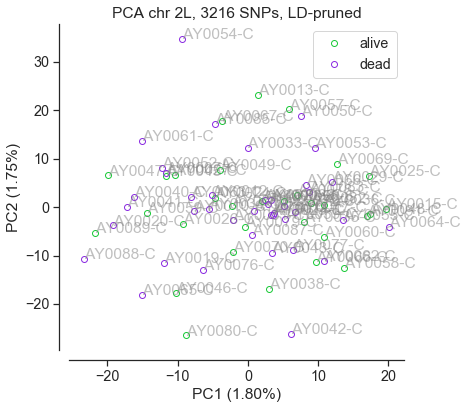

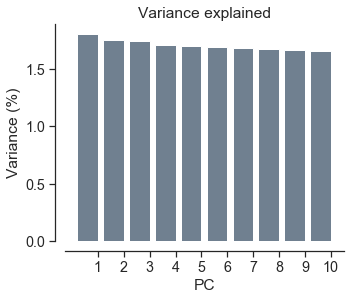

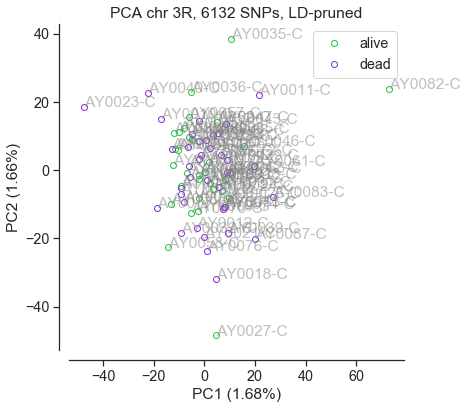

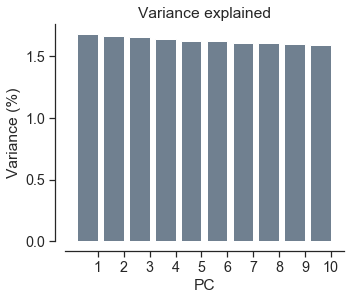

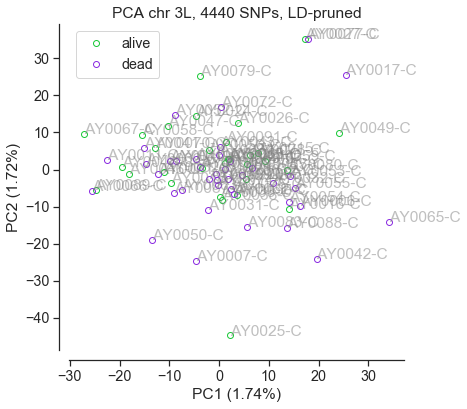

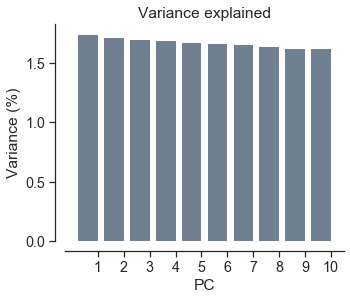

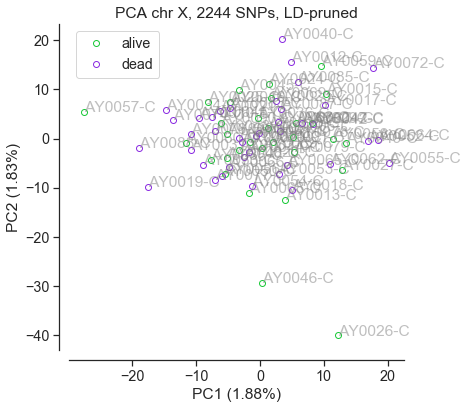

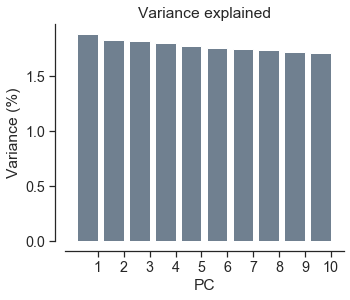

In [31]:
pdf_pages = PdfPages("%s/%s_fig_%s.pdf" % (outdir,outcode,"PCA"))



# PCA of LD-pruned genotypes in all chromosomes
# PCA1-2
pca_coo, pca_mod = allel.pca(genotyp_seg_naltAll_LDp)
fig,ax = plot_pca_coords(
    coords=pca_coo,model=pca_mod,pc1=0,pc2=1,
    colorpop1="g",colorpop2="m",
    title="PCA chr %s, %i SNPs, LD-pruned" % ("All",len(genotyp_seg_naltAll_LDp)))
for pii, pin in enumerate(samples_sub["ox_code"]):
    ax.annotate(s=pin,xy=(float(pca_coo[pii, 0]),float(pca_coo[pii, 1])),
                color="gray",alpha=0.5)
pdf_pages.savefig(fig,bbox_inches='tight')
# PCA1-3
fig,ax = plot_pca_coords(
    coords=pca_coo,model=pca_mod,pc1=0,pc2=2,
    colorpop1="g",colorpop2="m",
    title="PCA chr %s, %i SNPs, LD-pruned" % ("All",len(genotyp_seg_naltAll_LDp)))
for pii, pin in enumerate(samples_sub["ox_code"]):
    ax.annotate(s=pin,xy=(float(pca_coo[pii, 0]),float(pca_coo[pii, 2])),
                color="gray",alpha=0.5)
pdf_pages.savefig(fig,bbox_inches='tight')
# variance explained
fig = plot_pcavarexp(pcamodel=pca_mod,color="slategray",title="Variance explained")
pdf_pages.savefig(fig,bbox_inches='tight')




# PCA of all genotypes in all chromosomes
pca_coo, pca_mod = allel.pca(genotyp_seg_naltAll)
# PCA1-2
fig,ax = plot_pca_coords(
    coords=pca_coo,model=pca_mod,pc1=0,pc2=1,
    colorpop1="g",colorpop2="m",
    title="PCA chr %s, %i SNPs, all" % (
        "All",len(genotyp_seg_naltAll)))
for pii, pin in enumerate(samples_sub["ox_code"]):
    ax.annotate(s=pin,xy=(float(pca_coo[pii, 0]),float(pca_coo[pii, 1])),
                color="gray",alpha=0.5)
pdf_pages.savefig(fig,bbox_inches='tight')
# PCA1-3
fig,ax = plot_pca_coords(
    coords=pca_coo,model=pca_mod,pc1=1,pc2=2,
    colorpop1="g",colorpop2="m",
    title="PCA chr %s, %i SNPs, all" % (
        "All",len(genotyp_seg_naltAll)))
for pii, pin in enumerate(samples_sub["ox_code"]):
    ax.annotate(s=pin,xy=(float(pca_coo[pii, 1]),float(pca_coo[pii, 2])),
                color="gray",alpha=0.5)
pdf_pages.savefig(fig,bbox_inches='tight')
# variance explained
fig = plot_pcavarexp(pcamodel=pca_mod,color="slategray",title="Variance explained")
pdf_pages.savefig(fig,bbox_inches='tight')




# PCA of LD-pruned genotypes in all chromosomes
pdf_pages.savefig(fig,bbox_inches='tight')
# variance explained
fig = plot_pcavarexp(pcamodel=pca_mod,color="slategray",title="Variance explained")
pdf_pages.savefig(fig,bbox_inches='tight')

for chrom in chromlist:

    # PCA of all genotypes in all chromosomes
    pca_coo, pca_mod = allel.pca(genotyp_seg_nalt_LDp[chrom])
    fig,ax = plot_pca_coords(
        coords=pca_coo,model=pca_mod,pc1=0,pc2=1,
        colorpop1="g",colorpop2="m",
        title="PCA chr %s, %i SNPs, LD-pruned" % (chrom,len(genotyp_seg_nalt_LDp[chrom])))
    for pii, pin in enumerate(samples_sub["ox_code"]):
        ax.annotate(s=pin,xy=(float(pca_coo[pii, 0]),float(pca_coo[pii, 1])),
                    color="gray",alpha=0.5)
    pdf_pages.savefig(fig,bbox_inches='tight')
    # variance explained
    fig = plot_pcavarexp(pcamodel=pca_mod,color="slategray",title="Variance explained")
    pdf_pages.savefig(fig,bbox_inches='tight')

pdf_pages.close()